# Introduction.

These are some (modest) attempts at participating in Jigsaw's toxic comments classification problem. For now, I am not using any external data, only the training data given (which is limiting as it's a tiny dataset).

In [3]:
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Using TensorFlow backend.


# Data loading.

In [4]:
df = pd.read_csv('data/train.csv', index_col='id')
df_test = pd.read_csv('data/test.csv', index_col='id')
# One test input is missing data, so we will just replace it by an empty string.
df_test['comment_text'].fillna('', inplace=True)

In [5]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [6]:
len(df)

95851

# Pre-processing.

In [7]:
simple_tokens = df.comment_text.apply(gensim.utils.simple_preprocess)

In [8]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [9]:
tokenized_text = list(tokenizer[simple_tokens])

In [10]:
tokenized_text[0]

['nonsense',
 'kiss',
 'off',
 'geek',
 'what',
 'said',
 'is',
 'true',
 'll',
 'have',
 'your',
 'account',
 'terminated']

In [11]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [12]:
TARGET_CLASSES = df.columns[1:]
targets = df[TARGET_CLASSES].values

# Analysis

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

(0, 400)

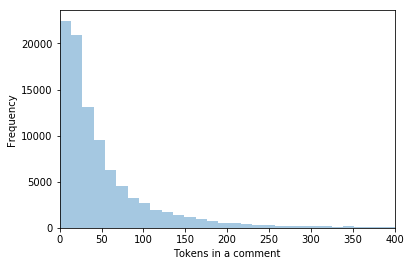

In [14]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

# Training word2vec on comment data.

In [15]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [16]:
word2vec.wv.most_similar('citation')

[('reference', 0.8087868094444275),
 ('citations', 0.7814565300941467),
 ('references', 0.7771475911140442),
 ('source', 0.7747196555137634),
 ('reliable_source', 0.7457165122032166),
 ('secondary_source', 0.7392337322235107),
 ('ref', 0.7367275357246399),
 ('sources', 0.7204996347427368),
 ('quote', 0.7049827575683594),
 ('cite', 0.6986434459686279)]

In [17]:
word2vec.wv.most_similar('stupid')

[('dumb', 0.8715893626213074),
 ('pathetic', 0.8467798233032227),
 ('crazy', 0.8234038352966309),
 ('bullshit', 0.7920104265213013),
 ('fucking', 0.7908686995506287),
 ('fool', 0.7828363180160522),
 ('moron', 0.7735713720321655),
 ('dude', 0.7664137482643127),
 ('sick', 0.7639930248260498),
 ('arrogant', 0.7635257244110107)]

# word2vec-based based model.

Aggregate word embeddings per comment (~ tf-idf weighted averaging), and use that as an input feature in a neural net with one hidden layer.

In [18]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(features, targets, epochs=10, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/10
86265/86265 [==============================] - 4s 47us/step - loss: 0.1027 - acc: 0.9677 - val_loss: 0.0826 - val_acc: 0.9700
Epoch 2/10
86265/86265 [==============================] - 3s 39us/step - loss: 0.0798 - acc: 0.9712 - val_loss: 0.0803 - val_acc: 0.9708
Epoch 3/10
86265/86265 [==============================] - 3s 39us/step - loss: 0.0783 - acc: 0.9716 - val_loss: 0.0804 - val_acc: 0.9711
Epoch 4/10
86265/86265 [==============================] - 3s 40us/step - loss: 0.0772 - acc: 0.9721 - val_loss: 0.0795 - val_acc: 0.9712
Epoch 5/10
86265/86265 [==============================] - 4s 44us/step - loss: 0.0768 - acc: 0.9723 - val_loss: 0.0787 - val_acc: 0.9711
Epoch 6/10
86265/86265 [==============================] - 3s 39us/step - loss: 0.0761 - acc: 0.9724 - val_loss: 0.0813 - val_acc: 0.9713
Epoch 7/10
86265/86265 [==============================] - 3s 40us/step - loss: 0.0756 - acc: 0.9725 - val_loss: 0.0770 - val_acc:

# Sequential models

Simply averaging embeddings across all terms in a comment loses interactions that can occur between words, and the importance of their position. Because of this, we will now experiment with position-aware models: LSTM and CNN.

In [21]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [22]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [23]:
max_idx = max(c for d in docs for c in d)
max_idx

136735

In [24]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

## LSTM (WIP)

We use an LSTM with an embedding layer, and use padded sequences as an input to the model.

In [25]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.25))
model.add(LSTM(256, recurrent_initializer='identity'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy')

ValueError: Identity matrix initializer can only be used for 2D square matrices.

In [ ]:
model.fit(padded_docs, targets, batch_size=256, epochs=10, validation_split=0.1)

## CNN

In [39]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model.fit(padded_docs, targets, batch_size=512, epochs=5, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/5
86265/86265 [==============================] - 65s 754us/step - loss: 0.5531 - acc: 0.9632 - val_loss: 0.2552 - val_acc: 0.9624
Epoch 2/5
86265/86265 [==============================] - 65s 755us/step - loss: 0.1059 - acc: 0.9774 - val_loss: 0.1616 - val_acc: 0.9625
Epoch 3/5
86265/86265 [==============================] - 65s 755us/step - loss: 0.0837 - acc: 0.9809 - val_loss: 0.1251 - val_acc: 0.9660
Epoch 4/5
86265/86265 [==============================] - 66s 769us/step - loss: 0.0748 - acc: 0.9823 - val_loss: 0.1000 - val_acc: 0.9749
Epoch 5/5
86265/86265 [==============================] - 66s 761us/step - loss: 0.0683 - acc: 0.9837 - val_loss: 0.0950 - val_acc: 0.9771


In [41]:
model.fit(padded_docs, targets, batch_size=512, epochs=10, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/10
86265/86265 [==============================] - 65s 756us/step - loss: 0.0639 - acc: 0.9847 - val_loss: 0.0957 - val_acc: 0.9769
Epoch 2/10
86265/86265 [==============================] - 66s 765us/step - loss: 0.0615 - acc: 0.9851 - val_loss: 0.0915 - val_acc: 0.9777
Epoch 3/10
86265/86265 [==============================] - 69s 805us/step - loss: 0.0586 - acc: 0.9856 - val_loss: 0.0922 - val_acc: 0.9771
Epoch 4/10
86265/86265 [==============================] - 66s 768us/step - loss: 0.0569 - acc: 0.9859 - val_loss: 0.0920 - val_acc: 0.9771
Epoch 5/10
86265/86265 [==============================] - 65s 753us/step - loss: 0.0549 - acc: 0.9865 - val_loss: 0.0973 - val_acc: 0.9768
Epoch 6/10
86265/86265 [==============================] - 68s 792us/step - loss: 0.0535 - acc: 0.9866 - val_loss: 0.0930 - val_acc: 0.9770
Epoch 7/10
86265/86265 [==============================] - 66s 769us/step - loss: 0.0526 - acc: 0.9867 - val_loss: 0.0

# Creating a submission.

In [28]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [43]:
test_input = [comment_to_sequential_input("Why are we having all these people from shithole countries come here?").reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 4.94%
severe_toxic: 0.82%
obscene: 1.76%
threat: 0.92%
insult: 1.89%
identity_hate: 1.79%


In [30]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in df_test.comment_text])

In [31]:
test_outputs = model.predict(test_inputs)

In [32]:
test_outputs[0]

array([ 0.42359537,  0.02407806,  0.09000999,  0.01083746,  0.10032999,
        0.0244122 ], dtype=float32)

In [33]:
output_df = df_test.reset_index()[['id']].copy()

In [34]:
for i, target_class in enumerate(TARGET_CLASSES):
    output_df[target_class] = test_outputs[:, i]

In [35]:
output_df[output_df.toxic > 0.5].sample(10, random_state=0).merge(df_test.reset_index(), on='id')

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,207776000712,0.948848,0.019023,0.383647,0.002692,0.281466,0.013564,"""This is ridiculous. """"It makes Iranians look ..."
1,473421599211,0.684538,0.020371,0.144640,0.007382,0.127685,0.017104,"OK, calm down. I only did it once so how the h..."
2,75859090464,0.999999,0.638960,0.999577,0.030429,0.996361,0.285101,"no fucking shit, dick head."
3,962041181389,1.000000,0.396993,0.999879,0.044877,0.998712,0.227803,"Sallary controversy \n\nArzel, watch your bac..."
4,511198810846,0.874407,0.020444,0.234701,0.007127,0.173478,0.014323,"""\n\nWhy in the FVCK would you give a """"love""""..."
5,669469110204,0.999987,0.117371,0.992761,0.078995,0.947661,0.092362,"HEY ALAN!\nYOU FUCKING SUCK MY DICK, you gaybo..."
6,643477166986,0.690494,0.007340,0.070389,0.004534,0.066467,0.008397,::::I replied here since this is where the dis...
7,390060787074,0.999694,0.157694,0.968267,0.020527,0.897413,0.074419,Screw you to goddamn hippies!!\n\nWikipedia Su...
8,75685472898,0.999981,0.379813,0.995993,0.019506,0.976859,0.155629,Text Edit\n\nFuck. Shit. Cunt.
9,946083055427,0.991652,0.098146,0.795065,0.014297,0.648909,0.061169,=FUCK U CUNT=


In [38]:
output_df.to_csv('submissions/cnn_0.csv', index=False)

# Annex

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution1D, Dense

model = Sequential()
model.add(Embedding(word2vec.vector_size))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def tokens_to_embedding(tokens):
    embeddings = [word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens if t in word2vec.wv.vocab]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

def text_to_embedding(text):
    return tokens_to_embedding(tokenizer[gensim.utils.simple_preprocess(text)])

text = 'hello moroccan friend is just a regular message without any insults'
model.predict(text_to_embedding(text).reshape(1, -1))

In [ ]:
test_tokens = tokenizer[df_test.comment_text.apply(gensim.utils.simple_preprocess)]

In [ ]:
test_features = [tokens_to_embedding(tokens) for tokens in test_tokens]